In [1]:
import numpy as np
from pyrex.core import Cookware
import matplotlib.pyplot as plt
from qcextender.dimensionlesswaveform import DimensionlessWaveform
from qcextender.functions import spherical_harmonics

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxscatalog/simulations/simulations.py:384: UserWarning: 
Downloads were turned off, so we are using the latest cached
simulations file, tagged v3.0.0, which may be out of date.
  warnings.warn(warning)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


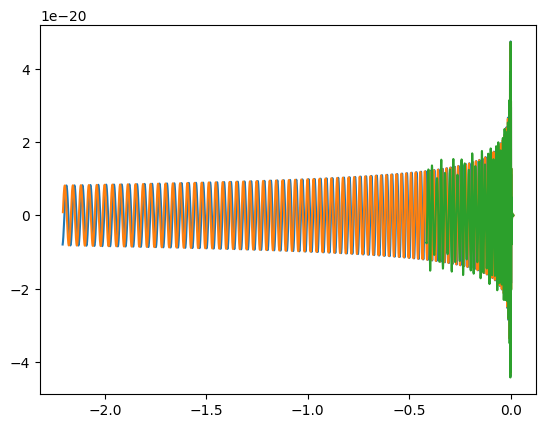

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


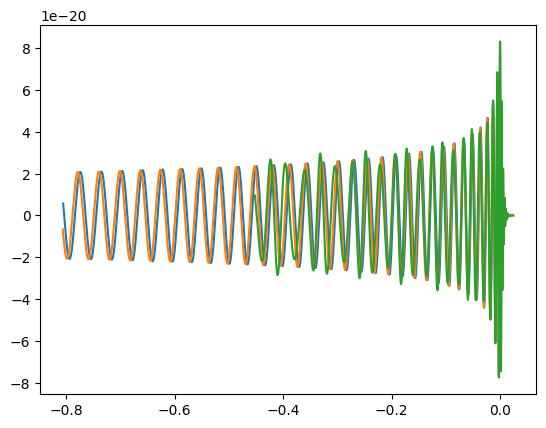

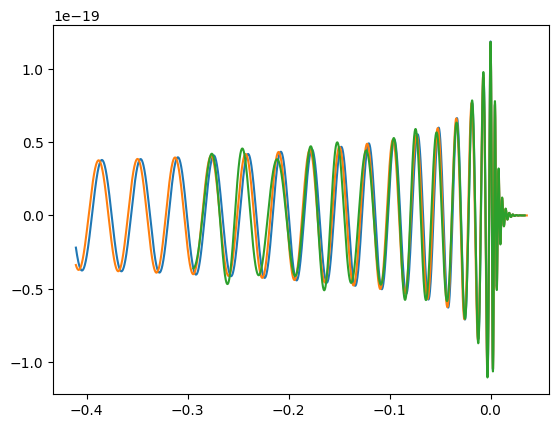

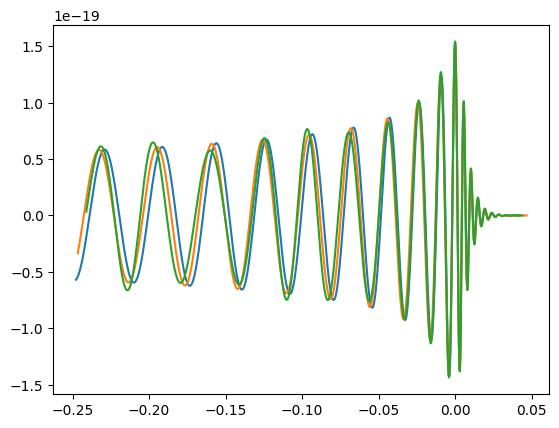

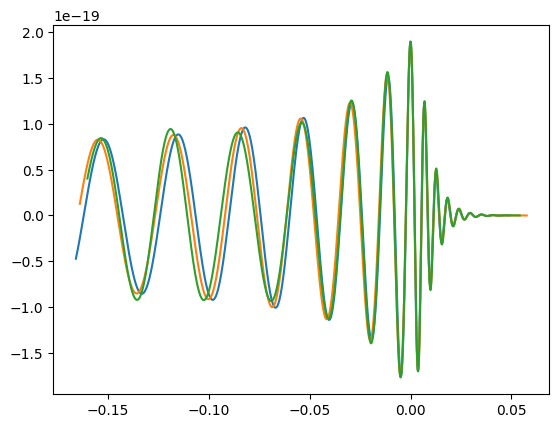

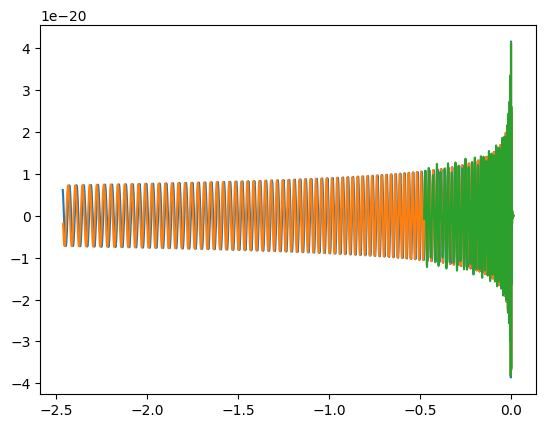

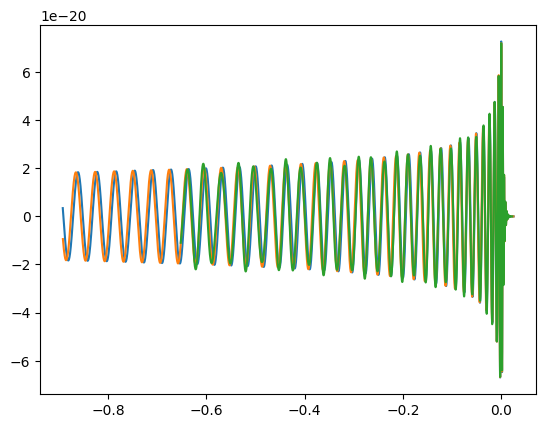

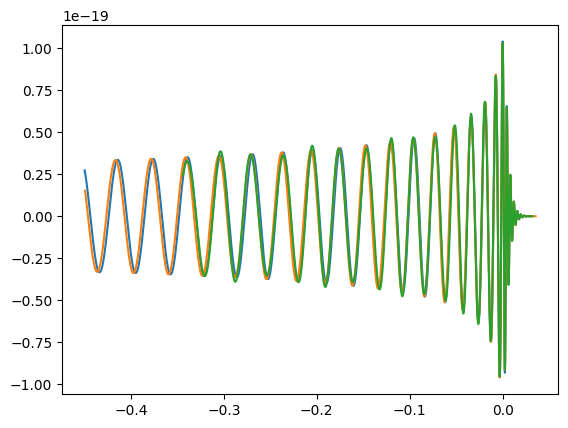

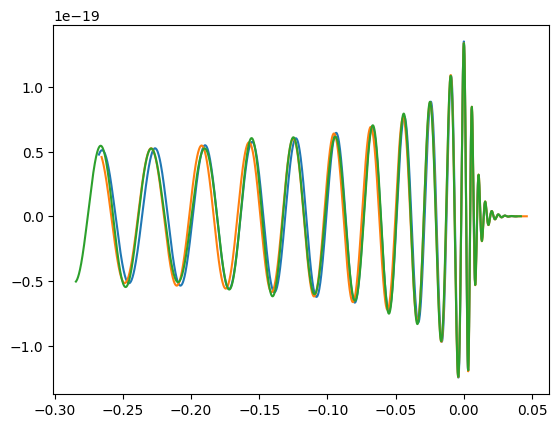

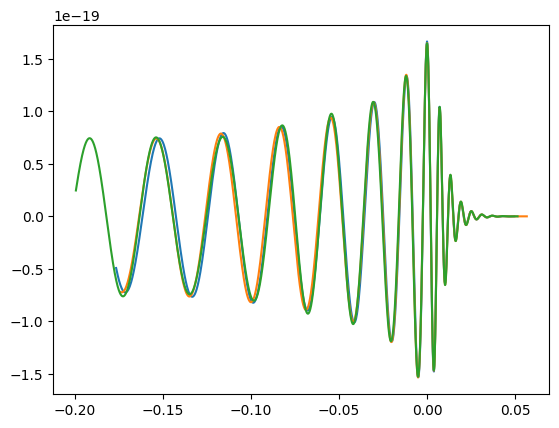

In [2]:
sims = ['SXS:BBH:1358', 'SXS:BBH:1365']#, 'SXS:BBH:1372', 'SXS:BBH:1359', 'SXS:BBH:1366', 'SXS:BBH:1360', 'SXS:BBH:1367', 'SXS:BBH:1361']
eccentricities = [0.099, 0.06]#, 0.092, 0.1, 0.095, 0.142, 0.096, 0.144] # These come from a fit
xs = [np.float64(0.14139682985076596), np.float64(0.132758281522539)]#, np.float64(0.11027495434452218), np.float64(0.11961646851279063), np.float64(0.12375690560387184), np.float64(0.14293288752385297), np.float64(0.13819894720860718), np.float64(0.12596736778632023)] # Made if using Glassware class using find_x
masses = np.linspace(25, 100, 5)
distance, inclination, coa_phase = 10, 0, 0
f_lower=25
mismatches = {}
for s, eccentricity, x in zip(sims, eccentricities, xs):
    sim = DimensionlessWaveform.from_sim(s)
    
    q = sim.metadata["q"]
    spin1x, spin1z, spin1y = 0, 0, 0
    spin2x, spin2z, spin2y = 0, 0, 0

    mismatch_seob, mismatch_phen = [], []
    for total_mass in masses:
        if q < 1:
            q = 1/q
        mass1 = q * total_mass / (q + 1)
        mass2 = total_mass / (q + 1)

        std_phenom = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'IMRPhenomD','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin2y,'spin2z':spin2z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}
        std_seob = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'approximant':'SEOBNRv4','spin1x':spin1x,'spin1y':spin1y,'spin1z':spin1z,'spin2x':spin2x,'spin2y':spin2y,'spin2z':spin2z,'inclination':inclination,'distance':distance,'coa_phase':coa_phase, 'x':x}

        phen_ecc = Cookware(**std_phenom).get_wave()
        seob_ecc = Cookware(**std_seob).get_wave()
        dsim = sim.to_Waveform(f_lower, total_mass, distance, inclination, coa_phase)

        plt.plot(phen_ecc.time, phen_ecc[2, 2])
        plt.plot(seob_ecc.time, seob_ecc[2, 2])
        plt.plot(dsim.time, dsim[2, 2])
        plt.show()

        mismatch_phen.append(1 - phen_ecc.match(dsim, f_lower))
        mismatch_seob.append(1 - seob_ecc.match(dsim, f_lower))
    mismatches[eccentricity] = (mismatch_phen, mismatch_seob)


In [3]:
print(mismatches)

{0.099: ([np.float64(0.3151514458032707), np.float64(0.1012640949591842), np.float64(0.05465177200943372), np.float64(0.028500533854920795), np.float64(0.016120863652892115)], [np.float64(0.2857692604624642), np.float64(0.0881088248592854), np.float64(0.051613165659421756), np.float64(0.020121725530489742), np.float64(0.013356912479539296)]), 0.06: ([np.float64(0.19329085709538052), np.float64(0.04037620552264398), np.float64(0.02643112429477068), np.float64(0.020004016569771133), np.float64(0.016524239500214533)], [np.float64(0.18289517978130243), np.float64(0.036651544962135185), np.float64(0.02776870842322665), np.float64(0.02316873358435234), np.float64(0.02351438501836478)])}


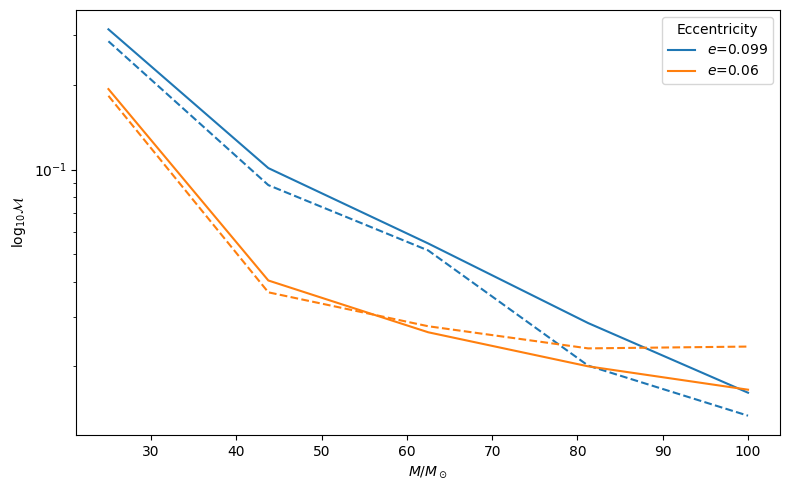

In [4]:
linestyles = {
    "SEOB": "--",
    "Phenom": "-"
}
plt.figure(figsize=(8, 5))
legend_handles = []
for eccentricity, (mismatch_phen, mismatch_seob) in mismatches.items():
    line_phen, = plt.plot(masses, mismatch_phen, linestyle=linestyles["Phenom"])
    plt.plot(masses, mismatch_seob, linestyle=linestyles["SEOB"], color=line_phen.get_color())
    legend_handles.append((line_phen, fr"$e$={eccentricity}"))

plt.legend(*zip(*legend_handles), title="Eccentricity")
plt.yscale("log")
# plt.xlim(25, 150)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\text{log}_{10} \mathcal{M}$")
plt.tight_layout()
plt.show()


In [5]:
# plt.figure(figsize=(10, 4))
# plt.plot(phen_ecc.time, seob_ecc.h22, label="SEOBNR")
# plt.plot(t_phen, phen_ecc.h22, label="Phenom")
# plt.plot(dsim.time, dsim[2, 2], label="NR simulation")
# plt.ylim(-1e-18, 1e-18)

# plt.legend()
# plt.tight_layout()
# plt.show()